## Project 2: Metis (Luther)
### Learn webscraping and linear regression with test train split

In [ ]:
# Project will be to examine the housing market in North Seattle, zip code 98103

In [ ]:
from __future__ import print_function, division

In [ ]:
import requests

requests.__path__

In [ ]:
# Scraping portion

from bs4 import BeautifulSoup
import re
import csv
import pandas as pd

# will be useful when calling bs4 on strings
import warnings
warnings.filterwarnings('ignore')

In [ ]:
zillow_url = 'https://www.zillow.com/homes/recently_sold/Seattle-WA-98103/house_type/99563_rid/90_days/' + \
'priced_sort/47.800933,-122.122307,47.539687,-122.56176_rect/10_zm/'
response_zillow = requests.get(zillow_url)

In [ ]:
print(response_zillow.status_code)

In [ ]:
page = response_zillow.text
# lxml is a library for processing XML and HTML in Python. We are parsing the data from txt to lxml
soup = BeautifulSoup(page, "lxml")

# The specific hrefs containing links to the listings include 'homedetails' in the string. Find and append all of the 
# relevent links to hrefs.

hrefs = []

for link in soup.find_all('a', href=re.compile('homedetails')): 
    href = link.get('href')
    hrefs.append(href)

# Length should be 25 for page 1.
print(len(hrefs))

In [ ]:
# I did not start with page 1 because the link did not follow the same pattern.
# Need to hit next page to get rest of search results. As of 07/10/17 there are 105 single family houses.
# At 25 listings per page, there are 5 pages total.

for num in range(2,6):
    next_url = 'https://www.zillow.com/homes/recently_sold/house_type/99563_rid/90_days/0_singlestory' +\
    '/priced_sort/47.800933,-122.122307,47.539687,-122.56176_rect/10_zm/' + str(num) + '_p/'
    response = requests.get(next_url)
    next_page = response.text
    soup = BeautifulSoup(next_page, "lxml")

    for link in soup.find_all('a', href=re.compile('homedetails')): 
        href = link.get('href')
        hrefs.append(href)
    print(len(hrefs))

In [ ]:
print(hrefs[:3])

In [ ]:
# Scrape for features in house listings. Start with tags.
href_info = []

for href in hrefs:
    home_url = 'https://www.zillow.com' + href
    response = requests.get(home_url)
    soup = BeautifulSoup(response.text, "lxml")
    
    # scrape for BR, Bath, Sqft (bbs)
    bbs = soup.find_all('span', class_='addr_bbs')
    
    # Scrape for sold price 
    price = soup.find_all('span', class_ = 'hdp-fact-value', text=re.compile('for \$'))
    
    # Scrape for year property was built
    age = soup.find_all('span', class_ = 'hdp-fact-value', text=re.compile('Built in '))

    # skipping listings that do not have BR, bath, sqft entries
    # (7/13/17) needed to also check for exactly 3 items (ran out of time!) 
    if not bbs:
        continue
        
    # check price before appending
    if price:    
        bbs.append(price[0])
    else:
        bbs.append(BeautifulSoup('<span class="hdp-fact-value">XXX 2017 for $0</span>')) # plug in dummy price
     
    # check age 
    if age:    
        bbs.append(age[0])
    else:
        bbs.append(BeautifulSoup('<span class="hdp-fact-value">Built in 0000</span>')) # plug in dummy year

    # append all 5 features to href_info together as a list
    href_info.append(bbs)


In [ ]:
[i for i, elt in enumerate(href_info) if not elt]
[i for i, elt in enumerate(href_info) if len(elt) != 5]

In [ ]:
href_info[2]

In [ ]:
# Dictionary with features as keys. Populate with scraped information from arrays in previous cell.
features = {'beds': [], 'baths': [], 'sqft': [], 'price':[], 'year-built': []}

# separate features beds, bath, sqft
for info in href_info:
    if not info:
        continue
    # take into account single bed (eg 1 bed)
    beds = info[0].text.replace(' bed', '').replace('s', '')
    if beds == '--':
        beds = None
    elif beds == 'Studio':
        beds = 0
    else:
        beds = int(beds)
    features['beds'].append(beds)
    
    # take into account single bath (eg 1 bath)
    baths = info[1].text.replace(' bath', '').replace('s', '')
    if baths == '--':
        baths = None
    else:
        baths = float(baths)
    features['baths'].append(baths)
    
    sqft = info[2].text.replace(' sqft', '')
    sqft = sqft.replace(',', '')
    if sqft == '--':
        sqft = None
    else:
        sqft = int(sqft)
    features['sqft'].append(sqft)


# Find the cost of a property within the hdp-fact-value class

    sold_price = info[3].text
    sold_price.find('$')
    cost = sold_price[sold_price.find('$')+1:]
    cost = int(cost.replace(',', ''))
    features['price'].append(cost)
    
# Find the year property was built within the hdp-fact-value class
    house = info[4].text
    year = house[-5:]
    year = int(year)
    features['year-built'].append(year)
    

In [ ]:
# covert features dictionary to pandas dataframe
listings_df = pd.DataFrame.from_dict(features)

In [ ]:
# output DataFrame of features to csv file

listings_df.to_csv('features_df.csv', index_label=False)

In [ ]:
listings_df.head()

In [ ]:
listings_df.info()

In [1]:
# Regression time!
import csv
import pandas as pd
import numpy as np
import matplotlib as plt
from seaborn import plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
%matplotlib inline

In [2]:
features_df = pd.read_csv('features_df.csv')

### Get to understand the data.

In [3]:
features_df.head(3)

,baths,beds,price,sqft,year-built
0,3.10,5,2900000,5390.0,1914
1,4.25,5,2000000,3984.0,2017
2,4.00,5,1965000,3720.0,2015


In [4]:
# Reorder column names to make slicing easier later.
features_df = features_df[['price', 'beds', 'baths', 'sqft', 'year-built']]
features_df.head()

,price,beds,baths,sqft,year-built
0,2900000,5,3.10,5390.0,1914
1,2000000,5,4.25,3984.0,2017
2,1965000,5,4.00,3720.0,2015
3,1925000,4,3.25,3340.0,2009
4,1895000,6,6.00,4400.0,2017


In [5]:
# test_train_split doesn't like hyphenated column names. changing to year from year-built.
features_df.rename(columns = {'year-built':'year'}, inplace = True)

In [6]:
# Verify rename worked.
features_df.columns

Index(['price', 'beds', 'baths', 'sqft', 'year'], dtype='object')

In [7]:
# 3 listings were plugged in with dummy year 0000. replace with NaN...
features_df['year'].replace(0000, np.nan, inplace=True)

In [8]:
# Take care of filling in any fields with missing data with mean of column
# This isn't kosher, should have split first into train and test sets then fill in with mean of train/test values.
features_df = features_df.fillna(features_df.mean(), inplace=True)

In [9]:
# Check out new mean of columns.
features_df.mean()
# Note that mean for year is now updated from 1884 to 1951.

price    917461.613636
beds          3.090909
baths         2.085465
sqft       1905.080460
year       1951.282353
dtype: float64

### Split the data into train and test slices

In [10]:
# First use all features.
y = features_df.iloc[:, :1]
X = features_df.iloc[:, 1:]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

### Standardize the *training* data

In [11]:
from sklearn.pipeline import Pipeline

pipe = [
    ('scale', preprocessing.StandardScaler()),
    ('ml', LinearRegression())
]
pipe = Pipeline(pipe)

In [12]:
pipe.fit(X_train, y_train)

Pipeline(steps=[('scale', StandardScaler(copy=True, with_mean=True, with_std=True)), ('ml', LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False))])

### Apply the transform to the test data
### Score all the data with the transform and plot

In [13]:
# Evaluate the model against the testing data
print('Test:', pipe.score(X_test, y_test))
print('Train:', pipe.score(X_train, y_train))
# Test: 0.758521361237
# Train: 0.807748170575

Test: 0.833043152312
Train: 0.755164852795


In [14]:
from sklearn.metrics import mean_squared_error
from sklearn.cross_validation import cross_val_score

/Users/macbook/anaconda/lib/python3.6/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [15]:
# MSE for first model
mse = mean_squared_error(y_test, pipe.predict(X_test))
print('MSE: ', mse)
# MSE:  52580876725.4 
# The sqrt of this is ~ 229305. Consider that the mean is 917461.6. Not horrible?

MSE:  34248878284.1


In [16]:
scores = cross_val_score(pipe, X_test, y_test, cv=4, scoring='neg_mean_squared_error')
print(-scores, np.mean(-scores))

[  5.35231947e+10   6.51115880e+10   3.98813133e+10   1.05378102e+10] 42263476540.9


In [17]:
predicted_y = pipe.predict(X_test)

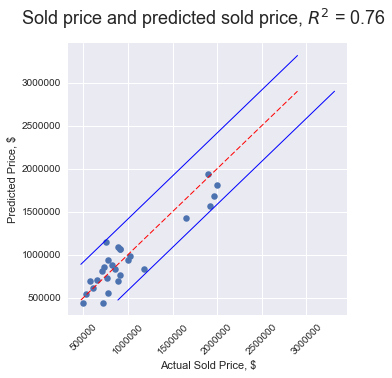

In [18]:
# want to plot predicted y vals from X_test against y_test
plt.figure(figsize=(5, 5)) # (width, height)
plt.suptitle('Sold price and predicted sold price, $R^2$ = 0.76', fontsize=18)
plt.plot(y_test, predicted_y, '.', markersize = 13)
plt.xticks(rotation = 45)
plt.xlabel('Actual Sold Price, $')
plt.ylabel('Predicted Price, $')
plt.plot([y.min(), y.max()], [y.min(), y.max()], 'k--', lw=1, color = 'r')
plt.plot([y.min() + np.std(y), y.max() + np.std(y)], [y.min(), y.max()], lw=1, color = 'b')
plt.plot([y.min(), y.max()], [y.min() + np.std(y), y.max() + np.std(y)], lw=1, color = 'b')

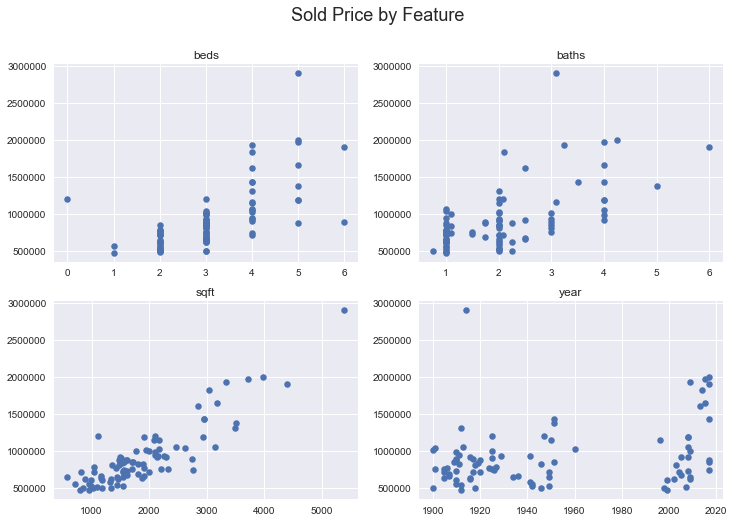

In [19]:
# Would be good to have: update this code to for loop through features to generate plots
# features = ['beds', 'baths', 'sqft', 'year']

plt.figure(figsize=(12, 8)) # (width, height)

# as an int, how to plot this one as line/bar graph with stdev?
plt.subplot(2, 2, 1)
#plt.axes.Axes.errorbar(X_test, y_test, features_df['price']) # This is wrong.
plt.plot(features_df['beds'], features_df['price'], '.', ms=13)
plt.title('beds')

plt.subplot(2, 2, 2)
plt.plot(features_df['baths'], features_df['price'], '.', ms=13)
plt.title('baths')

plt.subplot(2, 2, 3)
plt.plot(features_df['sqft'], features_df['price'], '.', ms=13)
plt.title('sqft')

plt.subplot(2, 2, 4)
plt.plot(features_df['year'], features_df['price'], '.', ms=13)
plt.title('year')
            
plt.suptitle('Sold Price by Feature', fontsize=18)

In [20]:
features_df.corr()
# Notice that sqft is highly correlated with sold price.

,price,beds,baths,sqft,year
price,1.000000,0.656336,0.612880,0.881093,0.290750
beds,0.656336,1.000000,0.636191,0.772445,0.249730
baths,0.612880,0.636191,1.000000,0.630156,0.575500
sqft,0.881093,0.772445,0.630156,1.000000,0.201093
year,0.290750,0.249730,0.575500,0.201093,1.000000


In [21]:
pipe2 = [
    ('scale', preprocessing.StandardScaler()),
    ('ml', LinearRegression())
]
pipe2 = Pipeline(pipe2)

In [22]:
# Model 2 looking at only sqft
y2 = features_df.iloc[:, :1] # y stays the same, which is sold price
X2 = features_df.iloc[:, 3:4] # feature interested in right now is sqft
X2_train, X2_test, y2_train, y2_test = train_test_split(X2, y2, test_size=0.3)
pipe2.fit(X2_train, y2_train)

# Evaluate the model against the testing data
print('Test:', pipe2.score(X2_test, y2_test))
print('Train:', pipe2.score(X2_train, y2_train))
# Test: 0.863975056282
# Train: 0.69288641072
# Better than the first model!

Test: 0.757771552535
Train: 0.779759833161


In [23]:
predicted_y2 = pipe2.predict(X2_test)

In [24]:
# Model 2: Find error on model which utilized only sqft
mse2 = mean_squared_error(y2_test, pipe2.predict(X2_test))
print('MSE for lr2: ', mse2)
scores2 = cross_val_score(pipe2, X2_test, y2_test, cv=4, scoring='neg_mean_squared_error')
print(-scores2, np.mean(-scores2))
# MSE is 35023895308.6
# Sqrt of this is ~ 187146.7. Error is smaller, but on same order of magnitude when compared to first model.

MSE for lr2:  38971184940.2
[  5.69803361e+10   1.57762787e+10   1.97004362e+10   9.58285222e+10] 47071393282.4


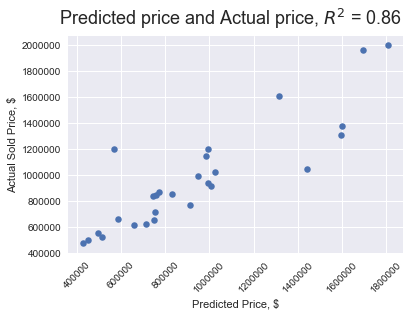

In [25]:
plt.plot(predicted_y2, y2_test, '.', markersize = 13)
plt.suptitle('Predicted price and Actual price, $R^2$ = 0.86', fontsize=18)
plt.xticks(rotation = 45)
plt.xlabel('Predicted Price, $')
plt.ylabel('Actual Sold Price, $')

In [26]:
# Is there a point in which sold price levels off/plateaus as size of property increases? Caveat: might not see this
# with current small dataset. Or might not see many properties with larger and larger sqft because Seattle is 
# constrained by water? Or might see this given more data as new construction and remodeled homes add square footage
# by building up.

# Nice to have for future: stratify by number of stories.

features_df['sr_sqft'] = features_df['sqft'].apply(lambda x: np.sqrt(x))

In [27]:
pipe3 = [
    ('scale', preprocessing.StandardScaler()),
    ('ml', LinearRegression())
]
pipe3 = Pipeline(pipe3)

In [28]:
# New model looking at only sr_sqft
y3 = features_df.iloc[:, :1]
X3 = features_df.iloc[:, -1:]
X3_train, X3_test, y3_train, y3_test = train_test_split(X3, y3, test_size=0.3)
pipe3.fit(X3_train, y3_train)

# Evaluate the model against the testing data
print('Test:', pipe3.score(X3_test, y3_test))
print('Train:', pipe3.score(X3_train, y3_train))

# Test: 0.744596429668 Comparable to original model using all features.
# Train: 0.699399622341

Test: 0.7208756706
Train: 0.69974811568


In [29]:
# Model 3: Find error on model which utilized only sr_sqft
mse3 = mean_squared_error(y3_test, pipe3.predict(X3_test))
print('MSE for lr3: ', mse3)
scores3 = cross_val_score(pipe3, X3_test, y3_test, cv=4, scoring='neg_mean_squared_error')
print(-scores3, np.mean(-scores3))
# However, MSE is 41717915644.8
# Sqrt of this is ~ 204249.6. Smaller error when compared to first model.

MSE for lr3:  20860037297.6
[  2.79677221e+10   3.55565130e+10   7.81797664e+09   9.26418429e+09] 20151598997.0


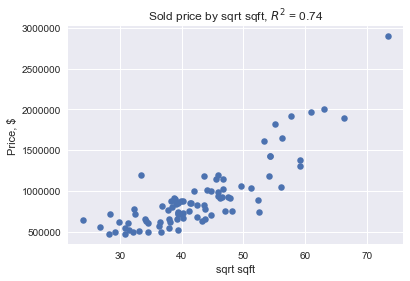

In [30]:
plt.plot(features_df['sr_sqft'], features_df['price'], '.', ms=13)
plt.title('Sold price by sqrt sqft, $R^2$ = 0.74')
plt.xlabel('sqrt sqft')
plt.ylabel('Price, $')

# This model does not perform as well as either of the previous 2 models. However will not rule out as this 
# dataset is small. 

In [ ]:
# Should I decide to pickle the model.
# features_df.to_pickle('soldprices1.pkl')